In [27]:
import pickle
import pickletools
import utils
import matplotlib.pyplot as plt
import numpy as np

    # def __init__(self, graph_path):
    #     self.draw_path = graph_path
    #     self.x = []
    #     self.numberUnProcessedMessages = {}
    #     self.numberUEWaitingResponse = []

    #     self.cumulative_total_messages = {}
    #     self.cumulative_message_from_UE_measurement = {}
    #     self.cumulative_message_from_UE_retransmit = {}
    #     self.cumulative_message_from_UE_RA = {}
    #     self.cumulative_message_from_satellite = {}

    #     self.UE_time_stamp = {}



In [28]:
import math
import random
def generate_points(n, R, x, y):
    def generate_one(R, x, y):
        r = R * math.sqrt(random.uniform(0, 1))
        theta = random.uniform(0, 1) * 2 * math.pi
        px = x + r * math.cos(theta)
        py = y + r * math.sin(theta)
        return px, py

    points = []
    for i in range(n):
        points.append(generate_one(R, x, y))
    return points

pos=generate_points(10000, 100000, 0, 0)
UE_positions = {}
i = 1
for p in pos:
    UE_positions[i] = p
    i += 1

# Single Data

In [29]:
with open('./LEOhandover/graph_datadata_object.pkl', 'rb') as inp:
    data = pickle.load(inp)

In [30]:
# Collect UE's data handover from the satellite 1
sat_id = 1
res = {}
for ue_id in data.UE_time_stamp:
    UE_time = data.UE_time_stamp[ue_id]
    for each in UE_time:
        if each['from'] == sat_id:
            res[ue_id] = each

def determine_range(value, min_value, max_value, num_ranges):
    if value < min_value or value > max_value:
        return None  # Value is outside the specified range

    range_size = (max_value - min_value) / num_ranges
    range_index = int((value - min_value) / range_size)

    return range_index

In [31]:
# get retransmission number
res_retransmission_number = {}
res_waiting_time = {}
res_success_or_failure = {}
res_alpha = {}

waiting_time_success = []
waiting_time_failure = []
retransmission_number_success = []
retransmission_number_failure = []

for id in res:
    r = res[id]
    res_retransmission_number[id] = len(r['timestamp']) - 2
    res_waiting_time[id] = np.log(r['timestamp'][-1] - r['timestamp'][0])
    res_success_or_failure[id] = r['isSuccess']

# Can remove
for id in res_success_or_failure:
    if str(res_success_or_failure[id]) == 'S':
        res_success_or_failure[id] = True

for id in res:
    if res_success_or_failure[id]:
        waiting_time_success.append(res_waiting_time[id])
        retransmission_number_success.append(res_retransmission_number[id])
        
    else:
        waiting_time_failure.append(res_waiting_time[id])
        retransmission_number_failure.append(res_retransmission_number[id])

num_range = 10
alpha_values = np.linspace(0.1, 1.0, num_range)
min_value_success = min(waiting_time_success)
max_value_success = max(waiting_time_success)
min_value_failure = min(waiting_time_failure)
max_value_failure = max(waiting_time_failure)
for id in res:
    if res_success_or_failure[id]:
        range_index = determine_range(res_waiting_time[id], min_value_success, max_value_success+1, num_range)
    else:
        range_index = determine_range(res_waiting_time[id], min_value_failure, max_value_failure+1, num_range)
    res_alpha[id] = alpha_values[range_index]

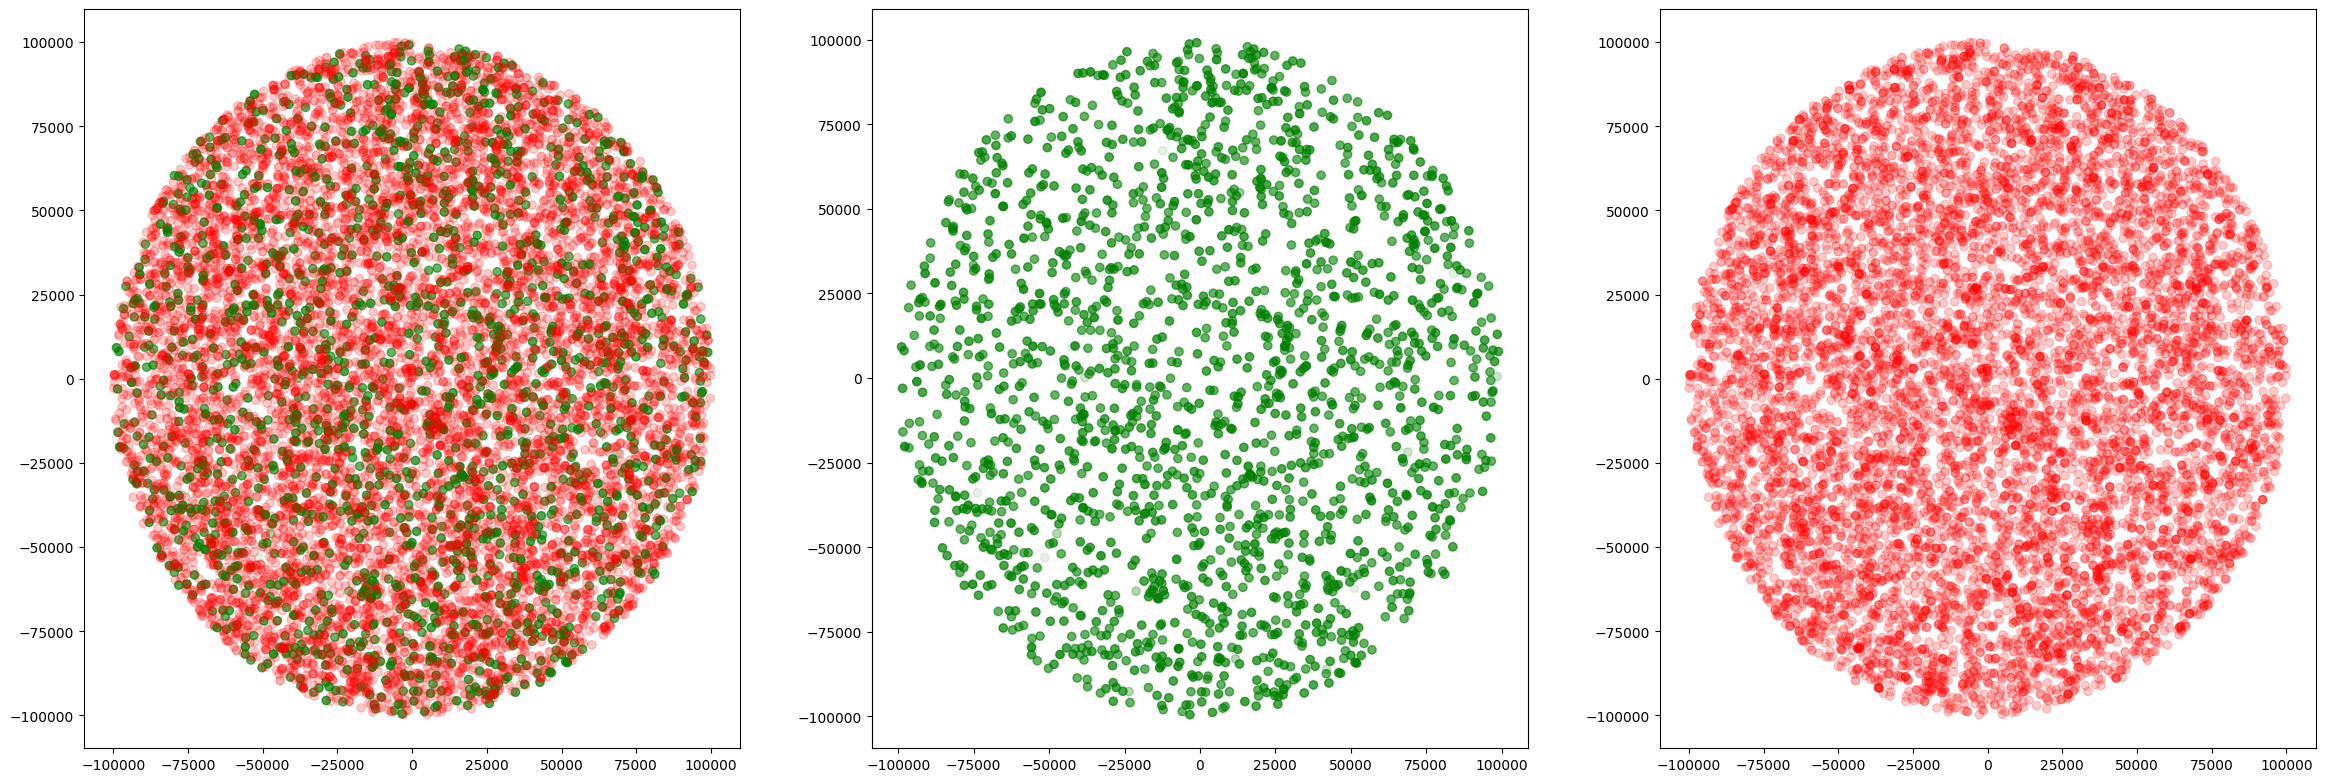

In [32]:
# import numpy as np
fig, axes = plt.subplots(1, 3, figsize=(36*0.8, 12*0.8))

# Combined Graph
pos_x = np.array([UE_positions[id][0] for id in UE_positions])
pos_y = np.array([UE_positions[id][1] for id in UE_positions])
res_success_or_failure_array = np.array([res_success_or_failure[id] for id in UE_positions])
colors = np.where(res_success_or_failure_array, 'g', 'red')
alpha = np.array([res_alpha[id] for id in UE_positions])
axes[0].scatter(x=pos_x, y=pos_y, c=colors, alpha=alpha)

# Success
success_UE_positions = {}
for id in UE_positions:
    if res_success_or_failure[id]:
        success_UE_positions[id] = UE_positions[id]
pos_x = np.array([success_UE_positions[id][0] for id in success_UE_positions])
pos_y = np.array([success_UE_positions[id][1] for id in success_UE_positions])
alpha = np.array([res_alpha[id] for id in success_UE_positions])
axes[1].scatter(x=pos_x, y=pos_y, c='g', alpha=alpha)

# Failure
failure_UE_positions = {}
for id in UE_positions:
    if not res_success_or_failure[id]:
        failure_UE_positions[id] = UE_positions[id]
pos_x = np.array([failure_UE_positions[id][0] for id in failure_UE_positions])
pos_y = np.array([failure_UE_positions[id][1] for id in failure_UE_positions])
alpha = np.array([res_alpha[id] for id in failure_UE_positions])
axes[2].scatter(x=pos_x, y=pos_y, c='r', alpha=alpha)

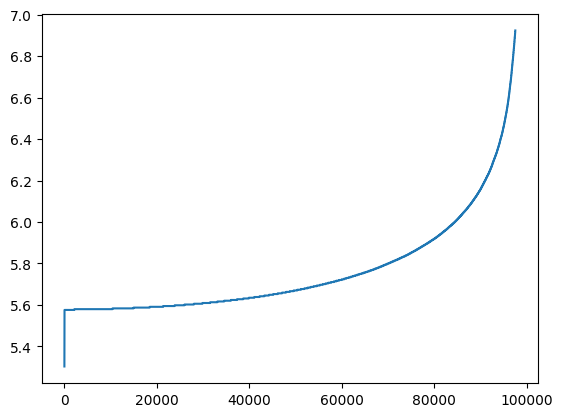

In [7]:
plt.plot(sorted(np.log(waiting_time_failure)))

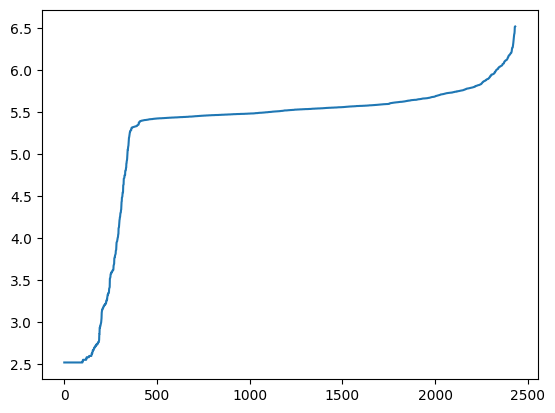

In [24]:
plt.plot(sorted(np.log(waiting_time_success)))

/var/folders/s1/p_7jy48x2gdb3jjp9p75009w0000gn/T/ipykernel_14847/658874550.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(sorted(np.log(retransmission_number_success)))


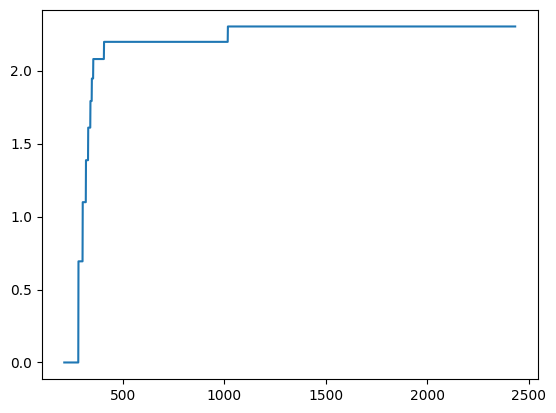

In [25]:
plt.plot(sorted(np.log(retransmission_number_success)))

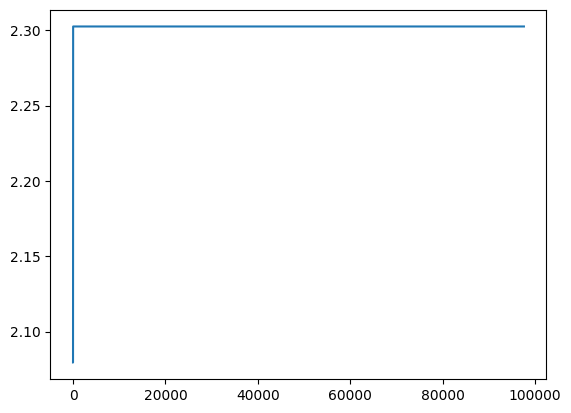

In [26]:
plt.plot(sorted(np.log(retransmission_number_failure)))

# Batch Graph

In [ ]:
with open('./10000/graph_datadata_object.pkl', 'rb') as inp:
    data10000 = pickle.load(inp)
with open('./15000/graph_datadata_object.pkl', 'rb') as inp:
    data15000 = pickle.load(inp)
with open('./20000/graph_datadata_object.pkl', 'rb') as inp:
    data20000 = pickle.load(inp)
with open('./25000/graph_datadata_object.pkl', 'rb') as inp:
    data25000 = pickle.load(inp)
with open('./30000/graph_datadata_object.pkl', 'rb') as inp:
    data30000 = pickle.load(inp)
with open('./35000/graph_datadata_object.pkl', 'rb') as inp:
    data35000 = pickle.load(inp)
with open('./40000/graph_datadata_object.pkl', 'rb') as inp:
    data40000 = pickle.load(inp)
with open('./45000/graph_datadata_object.pkl', 'rb') as inp:
    data45000 = pickle.load(inp)
with open('./50000/graph_datadata_object.pkl', 'rb') as inp:
    data50000 = pickle.load(inp)
with open('./55000/graph_datadata_object.pkl', 'rb') as inp:
    data55000 = pickle.load(inp)
with open('./60000/graph_datadata_object.pkl', 'rb') as inp:
    data60000 = pickle.load(inp)
with open('./65000/graph_datadata_object.pkl', 'rb') as inp:
    data65000 = pickle.load(inp)
with open('./70000/graph_datadata_object.pkl', 'rb') as inp:
    data70000 = pickle.load(inp)
x = data10000.x
label = ['10000', '15000', '20000', '25000', '30000', '35000', '40000', '45000', '50000', '55000', '60000', '65000', '70000']
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'deeppink', 'gold', 'orange', 'midnightblue', 'brown', 'grey']
data = [data10000, data15000, data20000, data25000, data30000, data35000, data40000, data45000, data50000, data55000, data60000, data65000, data70000]

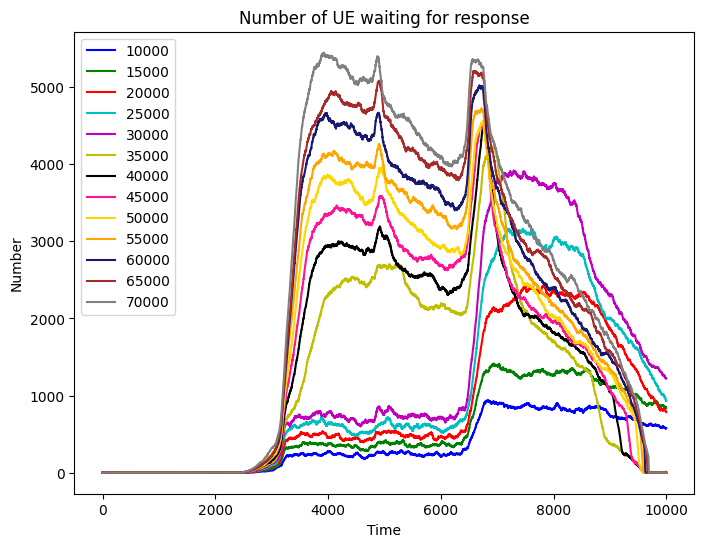

In [87]:
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].numberUEWaitingResponse, label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Number of UE waiting for response')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot

plt.savefig('number_UE_waiting_for_response.png', dpi = dpi)

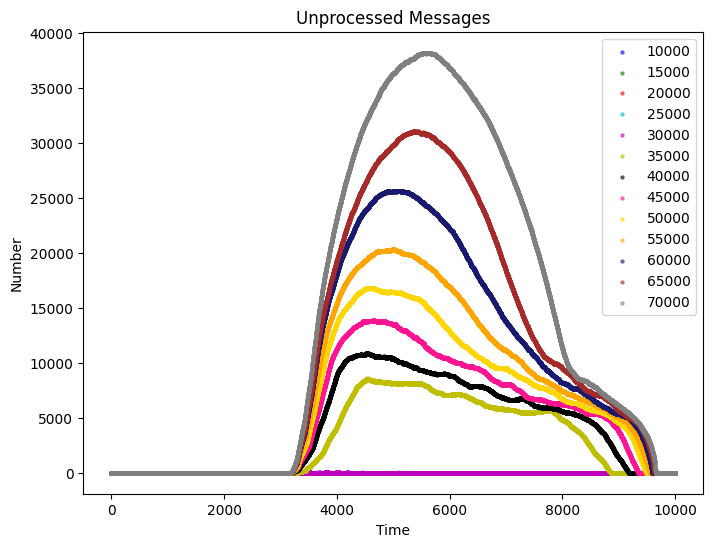

In [88]:
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.scatter(x, data[i].numberUnProcessedMessages[sat_id], label=label[i], c = color[i], s = 5, alpha = 0.5)


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Unprocessed Messages')
plt.legend()  # Add a legend to distinguish the lines

plt.savefig('number_unprocessed_tasks.png', dpi = dpi)




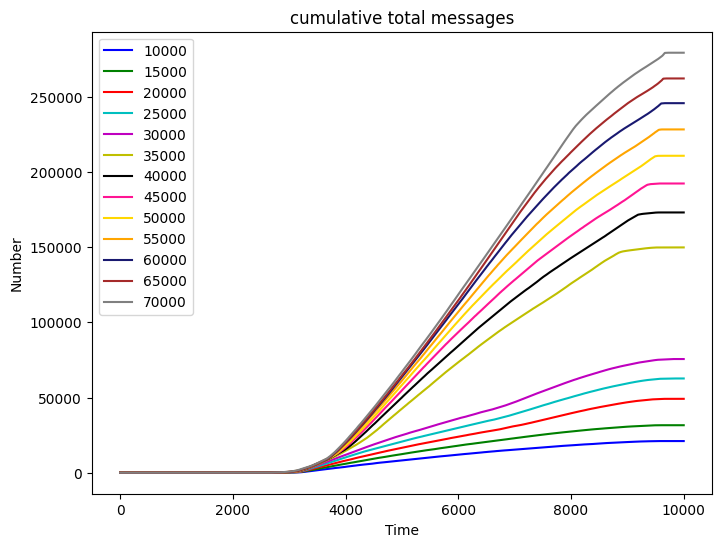

In [6]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])


# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative total messages in Satellite 1')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

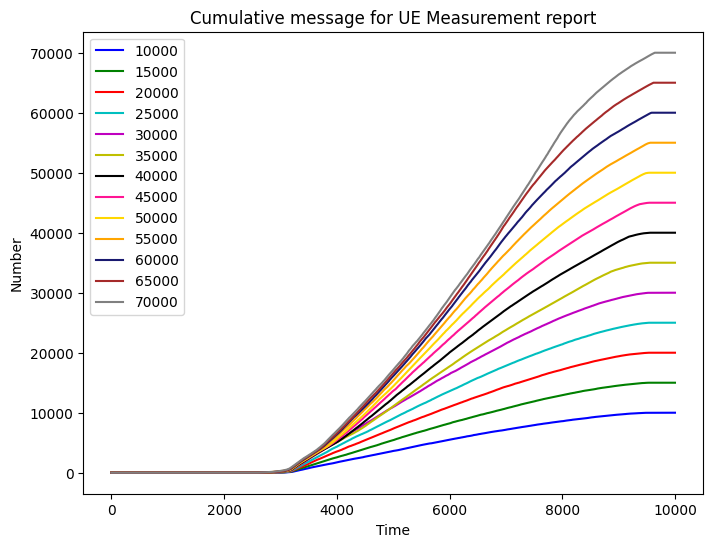

In [7]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the data
for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative message in Satellite 1 for UE Measurement report')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

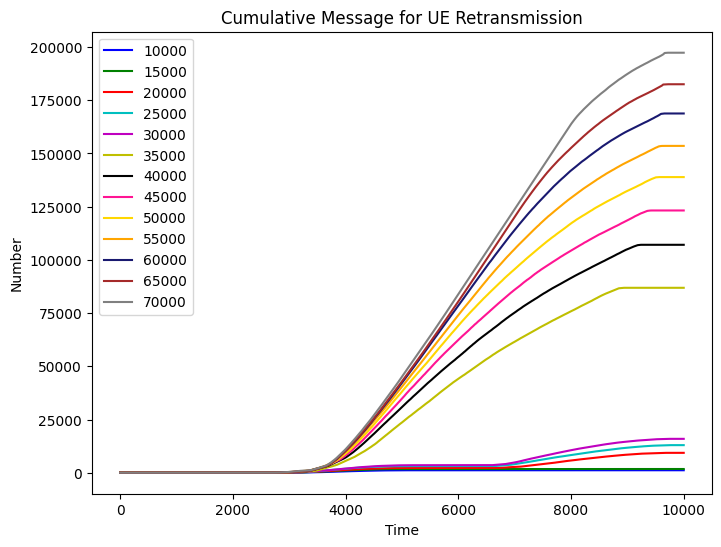

In [8]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 for UE Retransmission')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

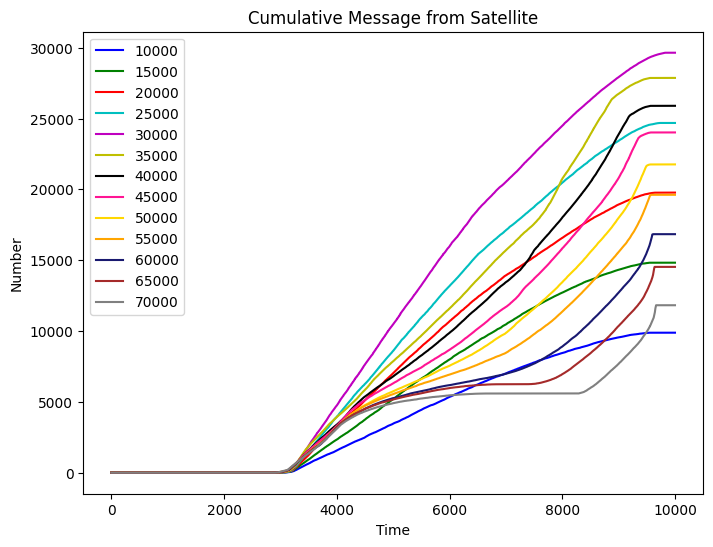

In [9]:
import matplotlib.pyplot as plt
sat_id = 1
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

for i in range(len(data)):
    plt.plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('Cumulative Message in Satellite 1 from Satellite')
plt.legend()  # Add a legend to distinguish the lines

# Show the plot
plt.show()

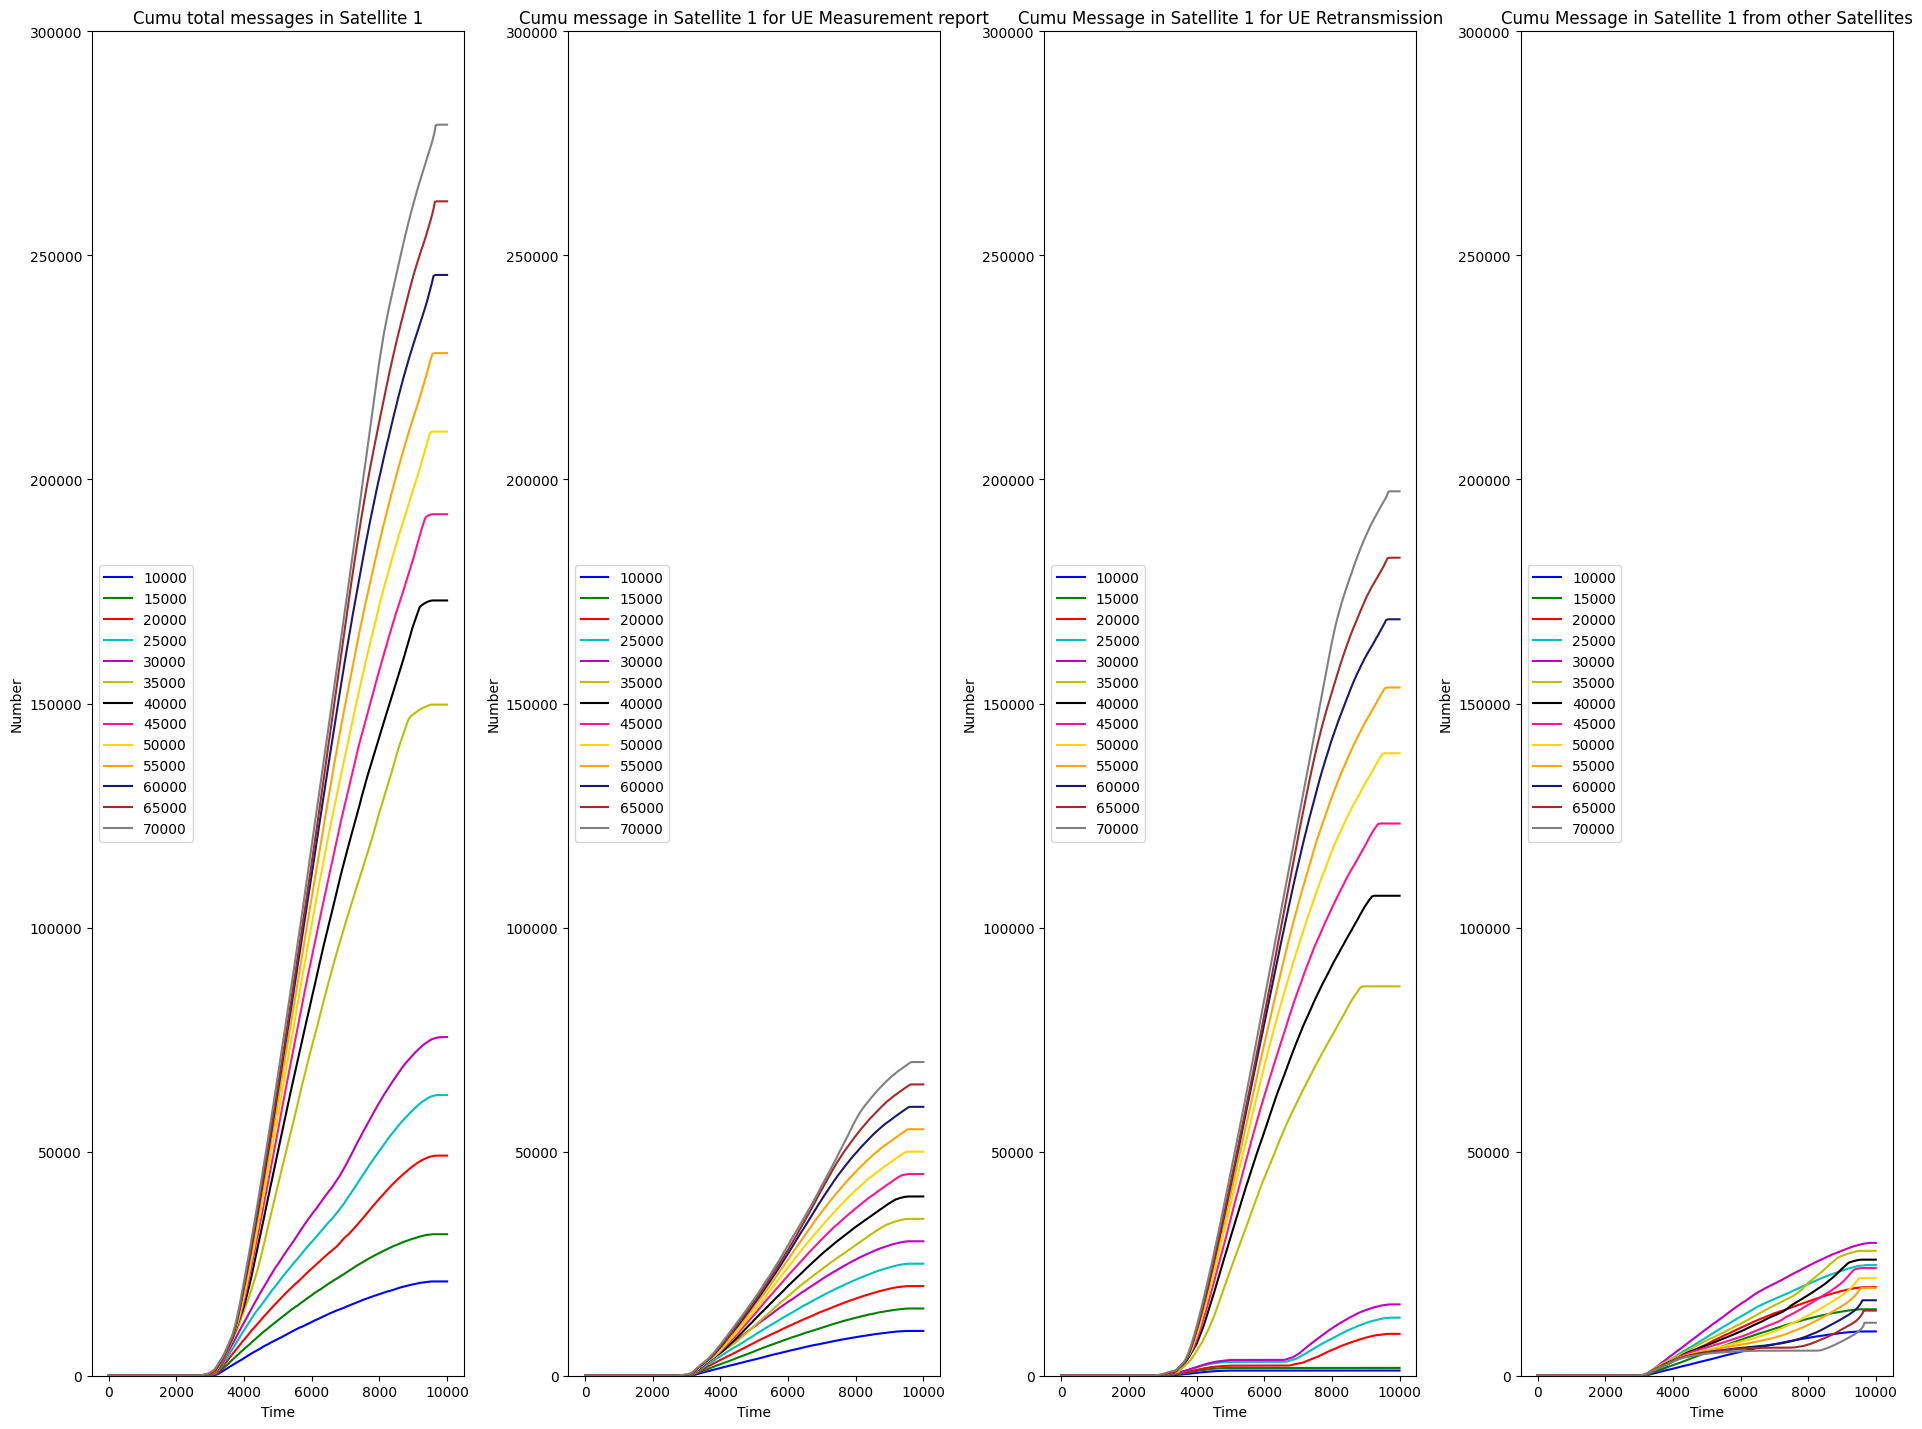

In [79]:
fig, axes = plt.subplots(1, 4, figsize=(24*0.8, 18*0.8))
sat_id = 1

axes[0].set_ylim(0, 300000)
for i in range(len(data)):
    axes[0].plot(x, data[i].cumulative_total_messages[sat_id], label=label[i], c = color[i])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Number')
axes[0].set_title('Cumu total messages in Satellite 1')
axes[0].legend(loc='center left')  # Add a legend to distinguish the lines

axes[1].set_ylim(0, 300000)
for i in range(len(data)):
    axes[1].plot(x, data[i].cumulative_message_from_UE_measurement[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Number')
axes[1].set_title('Cumu message in Satellite 1 for UE Measurement report')
axes[1].legend(loc='center left')  # Add a legend to distinguish the lines

axes[2].set_ylim(0, 300000)
for i in range(len(data)):
    axes[2].plot(x, data[i].cumulative_message_from_UE_retransmit[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Number')
axes[2].set_title('Cumu Message in Satellite 1 for UE Retransmission')
axes[2].legend(loc='center left')

axes[3].set_ylim(0, 300000)
for i in range(len(data)):
    axes[3].plot(x, data[i].cumulative_message_from_satellite[sat_id], label=label[i], c = color[i])

# Customize the plot (optional)
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Number')
axes[3].set_title('Cumu Message in Satellite 1 from other Satellites')
axes[3].legend(loc='center left')
plt.tight_layout()

dpi = 300
plt.savefig('cumulative_togther.png', dpi = dpi)

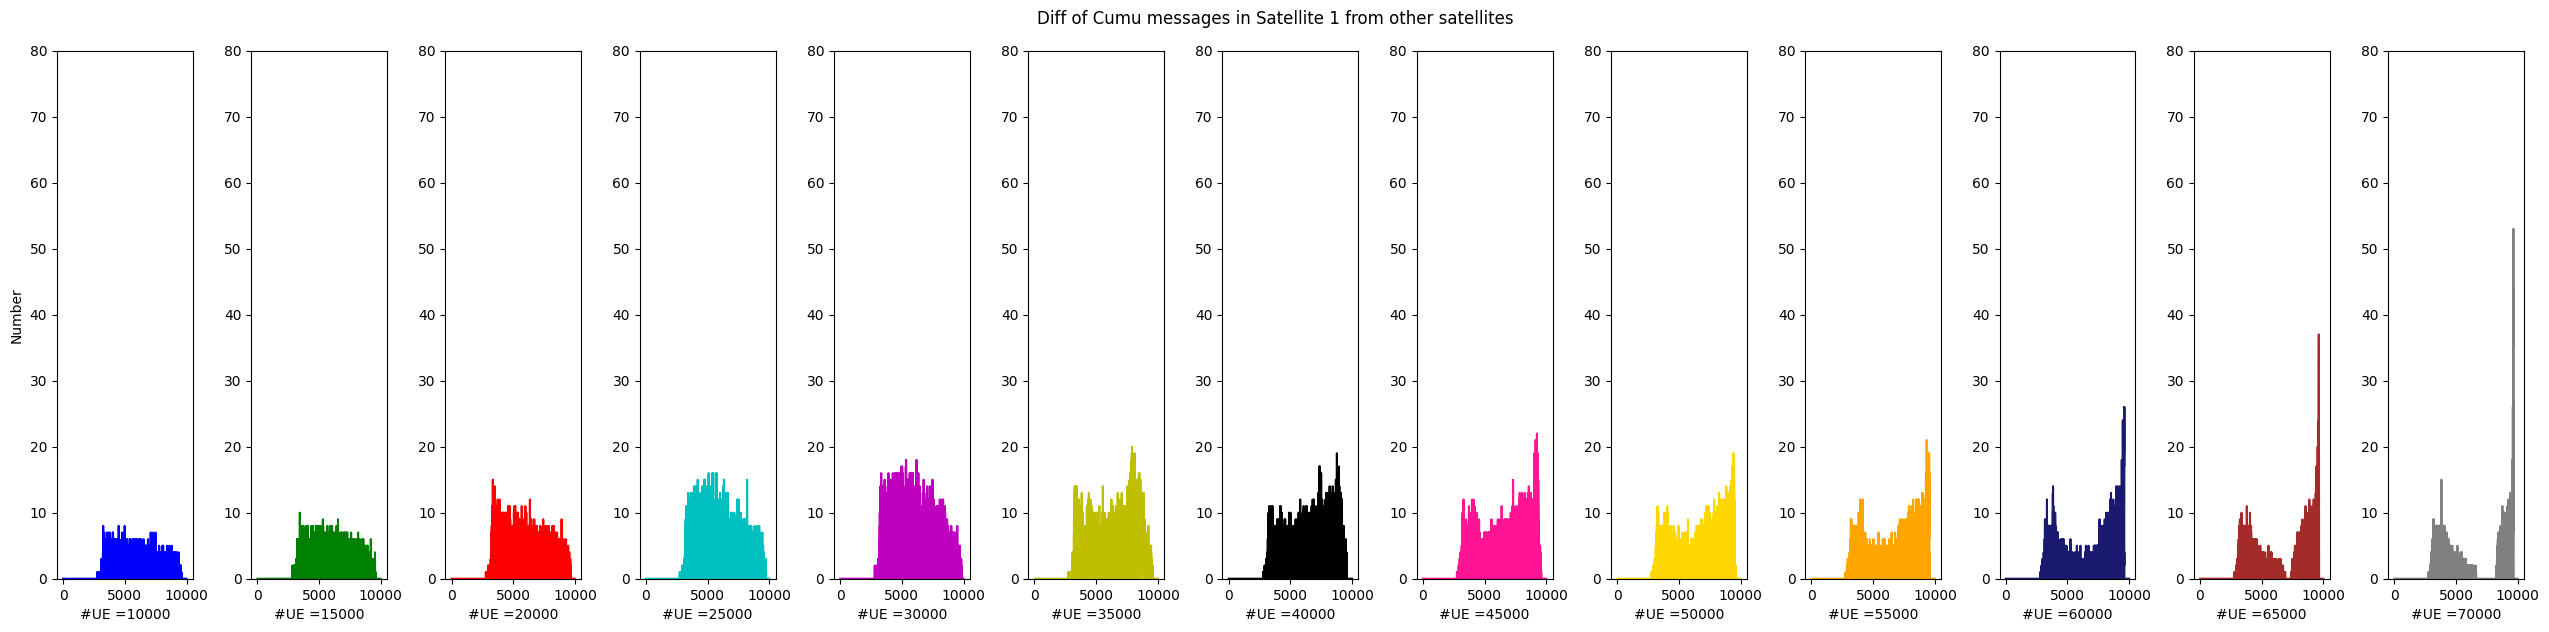

In [85]:
fig, axes = plt.subplots(1, len(data), figsize=(32*0.8, 8*0.8))
sat_id = 1

for i in range(len(data)):
    axes[i].set_ylim(0, 80)
    axes[i].plot(x[1:], np.diff(data[i].cumulative_message_from_satellite[sat_id]), label=label[i], c = color[i])
    axes[i].set_xlabel('#UE =' + str(label[i]))
    axes[0].set_ylabel('Number')
   # axes[0].legend(loc='center left')  # Add a legend to distinguish the lines
fig.suptitle('Diff of Cumu messages in Satellite 1 from other satellites')
# Centered title above subplots
#cumulative_total_messages
#cumulative_message_from_UE_measurement
#cumulative_message_from_UE_retransmit
#cumulative_message_from_satellite

plt.tight_layout()

dpi = 300
plt.savefig('diff_from_other_sat.png', dpi = dpi)